In [18]:
import surprisal
import matplotlib.pyplot as plt
import math
import numpy as np
import torch

In [2]:
import importlib

In [504]:
importlib.reload(surprisal)

<module 'surprisal' from '/Users/benjaminnewman/Documents/Machine Learning/Linguistics/openai-transformer-lm/pytorch-openai-transformer-lm/surprisal.py'>

In [3]:
sa = surprisal.SurprisalAnalyzer()

HELLO THERE!
Loading weights...


In [4]:
sa.get_surprisal("I am a person who", "eats")

array([9.876381], dtype=float32)

In [69]:
sa.get_surprisal_pos("I am a person who", "ADV", k=1000)

4.8410664

In [70]:
sa.get_entropy_pos("I am a person who", k=1000)

0.45697477

In [20]:
sa.get_continuations("I am a person who", verbose=True)

I am a person who
	...can</w> (0.1186)
	...is</w> (0.0904)
	...has</w> (0.0777)
	...does</w> (0.0614)
	...knows</w> (0.0475)
	...loves</w> (0.0283)
	...will</w> (0.0280)
	...believes</w> (0.0231)
	...likes</w> (0.0210)
	...'s</w> (0.0183)


(['can',
  'is',
  'has',
  'does',
  'knows',
  'loves',
  'will',
  'believes',
  'likes',
  "'s"],
 array([0.11860976, 0.09042414, 0.07769221, 0.06142825, 0.0475246 ,
        0.02827507, 0.02797416, 0.02306334, 0.02101   , 0.01826883],
       dtype=float32))

In [71]:
# no parser
sa.get_pos_continuations("I am a person who", k=1000)

(['VERB',
  'ADV',
  'PUNCT',
  'PRON',
  'ADP',
  'NOUN',
  'CCONJ',
  'DET',
  'INTJ',
  'ADJ',
  'X',
  'NUM',
  'PART',
  'SPACE'],
 array([9.18981671e-01, 3.48894261e-02, 7.79883517e-03, 4.97046951e-03,
        3.65637359e-03, 1.69705157e-03, 7.20013806e-04, 7.00726523e-04,
        6.95723516e-04, 6.23796310e-04, 5.37207408e-04, 1.15768875e-04,
        8.07690376e-05, 6.83510225e-05], dtype=float32))

In [156]:
# parser
sa.get_pos_continuations("I am a person who", k=100)

(['VERB', 'ADV', 'PUNCT', 'PRON'],
 array([0.81777555, 0.02078803, 0.00516793, 0.00264959], dtype=float32))

In [9]:
def plot_surprisal(sent):
    """
    plot the incremental perplexity and surprisal of a given sentence underneath each other
    """
#     sent = sent.split(" ")
#     surprisals, probabilities = get_surprisal(sent)
#     pps = [perplexity(prob_dist.flatten()) for prob_dist in probabilities]
#     ents = [entropy(prob_dist.flatten()) for prob_dist in probabilities]
    
    
    surprisals, entropies, sh_ratios, tokens = sa.get_s_h_shr_sentence(sent)
    
    
    # graphing
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = len(tokens)
    plt.rcParams["figure.figsize"] = fig_size # pretty much 1:1 ratio between figure size and # of tokens
    # sh-ratio subplot - shifted one to right to get perplexity AT word (want to know: when we 
    # chose this word, what was the average branching factor? or how hard should it have been to choose this word?)
    plt.subplot(2, 1, 1)
    plt.plot(range(len(sh_ratios)), sh_ratios, label="ratio")
    plt.xticks(range(len(tokens) - 1), tokens[1:])
    plt.legend()
    plt.title("surprisal - entropy ratio - %s"%(sent))
    
    # surprisal subplot
    plt.subplot(2, 1, 2)
    #plt.subplot(1, 1, 1)
    plt.plot(range(len(surprisals)), surprisals, label="word surprisal")
    plt.plot(range(len(entropies)), entropies, label="entropy")
    plt.xticks(range(len(tokens) - 1), tokens[1:])
    plt.legend()
    plt.title("Surprisal - %s"%(sent))
    
    plt.tight_layout() # avoids overlap
    plt.show()

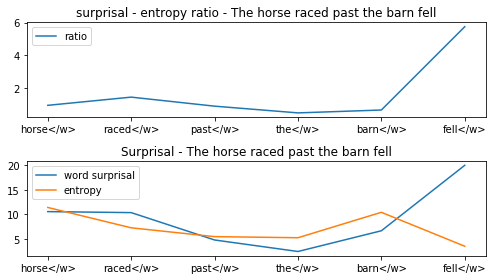

In [10]:
plot_surprisal("The horse raced past the barn fell")

In [11]:
def plot_next_pos_dist(sentence):
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    pos_tags, pos_tag_probs = sa.get_pos_continuations(sentence, 100)
    plt.bar(range(len(pos_tag_probs)), pos_tag_probs)
    plt.xticks(range(len(pos_tags)), pos_tags, rotation=90)
    plt.title("POS Tags Distribution - %s"%sentence)
    plt.show()
    
def plot_next_pos_dist_ind(sentence, sentence_indices):
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    cont_tensor = sa._get_continuation_tensor([sentence_indices])
    words, probs = sa._get_continuations(cont_tensor, k=100)
    pos_tags, pos_tag_probs = sa._get_pos_continuations(sentence, words, probs)
    plt.bar(range(len(pos_tag_probs)), pos_tag_probs)
    plt.xticks(range(len(pos_tags)), pos_tags, rotation=90)
    plt.title("POS Tags Distribution - %s"%sentence)
    plt.show()
    

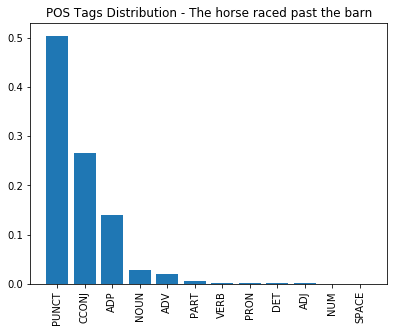

In [12]:
plot_next_pos_dist("The horse raced past the barn")

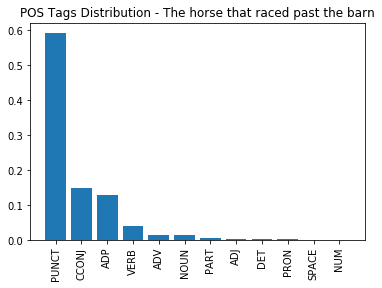

In [88]:
plot_next_pos_dist("The horse that raced past the barn")

In [89]:
plot_next_pos_dist("I know I guy that lived on a farm and liked to go down to the horse races. The horse that raced past the barn")

In [91]:
plot_next_pos_dist("he told me the horse that raced past the barn")

In [94]:
plot_next_pos_dist(". The horse that raced past the barn")

In [102]:
plot_next_pos_dist(". A horse that raced past the barn")

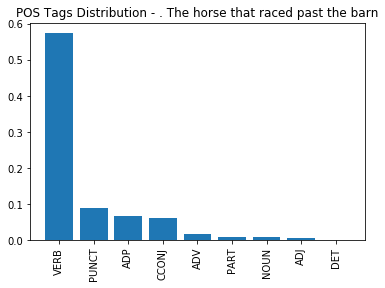

In [103]:
plot_next_pos_dist(". The horse that raced past the barn")

# Analyze Corpus from Sturt et al., 1999

Can we replicate Linzen et al's results?

In [116]:
# read corpus
garden_paths_nps = []
garden_paths_npz = []

with open("data/gardenpath.txt", "r") as gpfile:
    s = True
    for line in gpfile:
        line = "".join(line.split("/ ")) # ignore slashes (for now)
        line = " ".join([l if len(l) > 0 else "" for l in line.split(" ")[1:]]) # ignore numbers
        line = line.strip()
        if s:
            garden_paths_nps.append(line)
        else:
            garden_paths_npz.append(line)
        s = not s

In [120]:
# let's just focus on the NPS garden paths for now
garden_paths = []
garden_paths_unam = []

with open("data/gardenpaths_nps.txt", "r") as gpfile:
    ambig = True
    for line in gpfile:
        line = " ".join(line.split(" ")[1:]) # ignore numbers
        line = line.strip()
        if ambig:
            garden_paths.append(line)
        else:
            garden_paths_unam.append(line)
        ambig = not ambig

[481, 12068, 9425, 2994, 481, 15123, 7049, 636, 580, 2097, 963, 1443, 239]


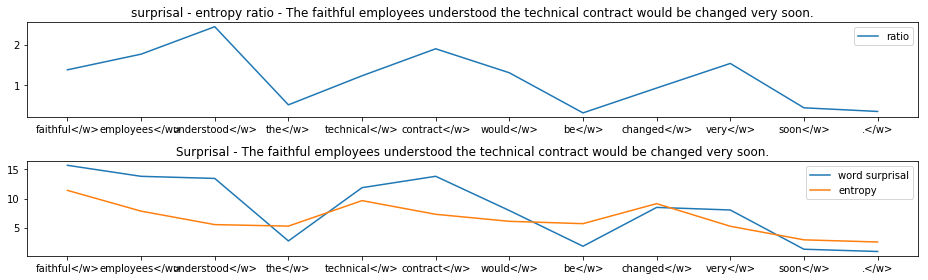

[481, 4427, 11052, 19720, 2994, 481, 563, 7511, 18756, 636, 580, 12125, 491, 481, 7138, 239]


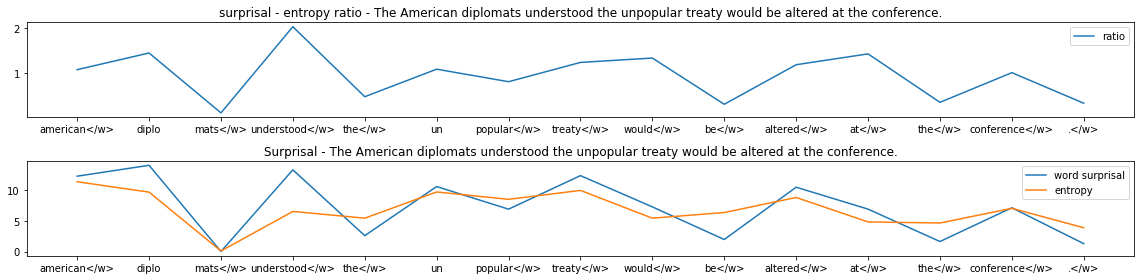

[481, 1669, 1157, 4617, 481, 8281, 18733, 558, 485, 580, 2118, 485, 481, 11566, 239]


[481, 1669, 762, 4617, 481, 5558, 1267, 816, 725, 5528, 815, 781, 239]


[481, 5440, 1122, 762, 7359, 481, 2540, 4764, 558, 8952, 485, 481, 2666, 239]


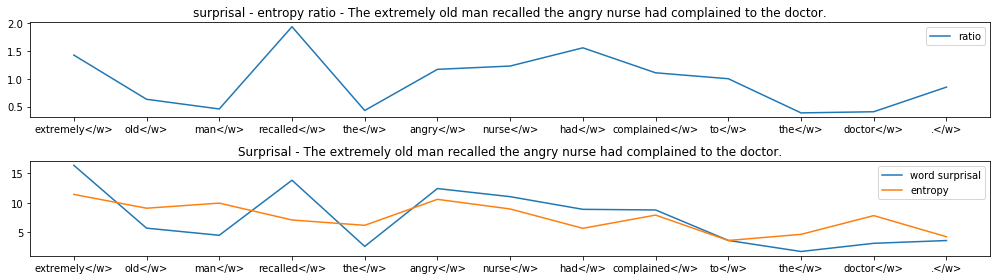

[481, 7065, 37159, 1172, 481, 2575, 3275, 558, 9534, 4855, 609, 500, 481, 7341, 25535, 239]


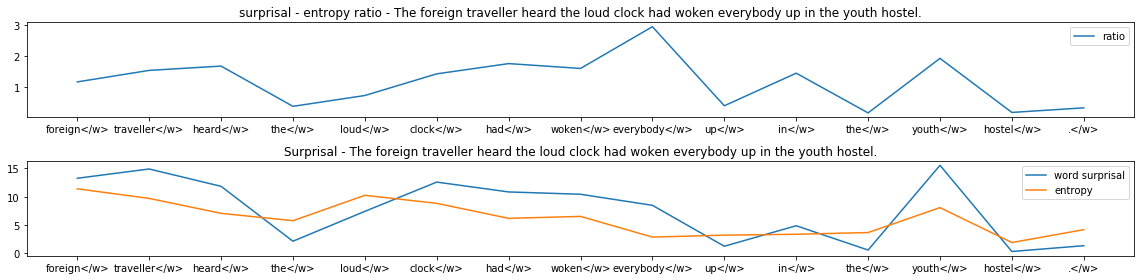

[481, 30198, 18141, 6396, 481, 35267, 1734, 636, 580, 11229, 504, 481, 1130, 4268, 239]


[481, 8426, 7467, 10611, 481, 19304, 2493, 1744, 714, 500, 246, 9771, 239]


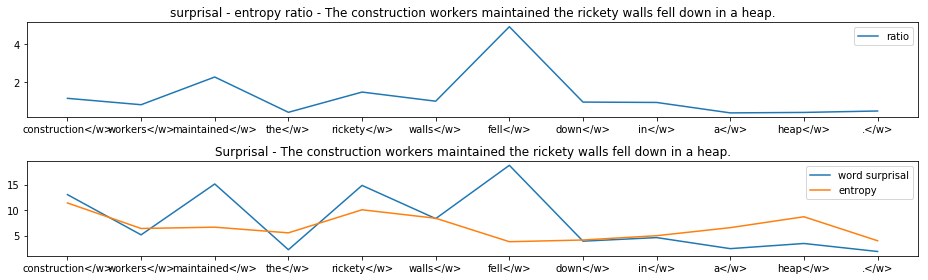

[481, 12843, 15443, 4549, 481, 8253, 17668, 509, 1505, 500, 481, 4970, 239]


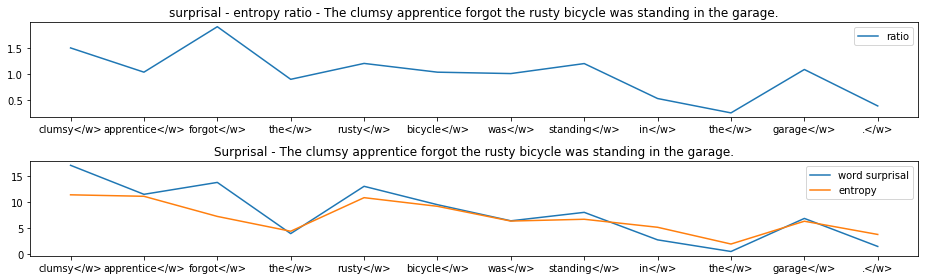

[481, 13921, 11566, 4033, 481, 6881, 5350, 636, 883, 246, 2204, 491, 481, 2500, 239]


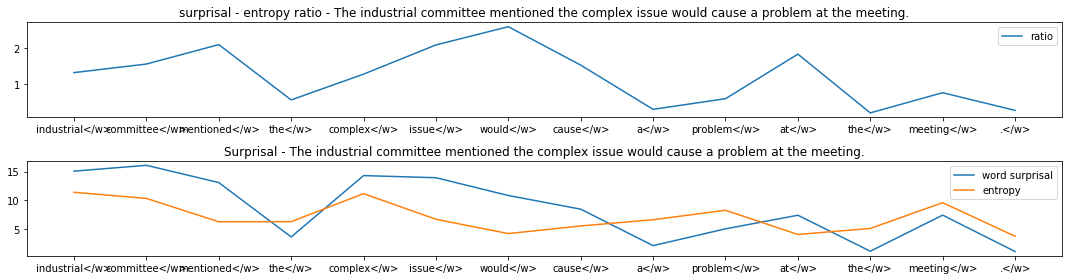

[481, 7585, 3409, 1132, 481, 5528, 5330, 6442, 3953, 1272, 2742, 2167, 481, 11151, 239]


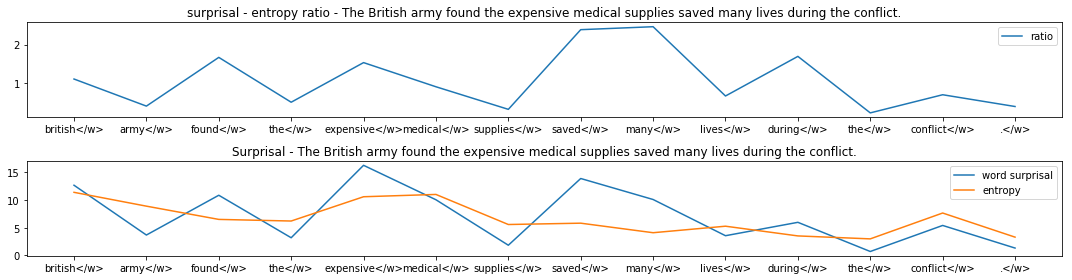

[481, 26478, 14916, 1132, 481, 2752, 9881, 635, 580, 963, 6746, 485, 481, 3336, 239]


[481, 39048, 40145, 4771, 481, 7227, 7176, 558, 2238, 500, 481, 4144, 239]


[481, 11807, 9987, 4771, 481, 33621, 34312, 636, 580, 1655, 562, 7792, 239]


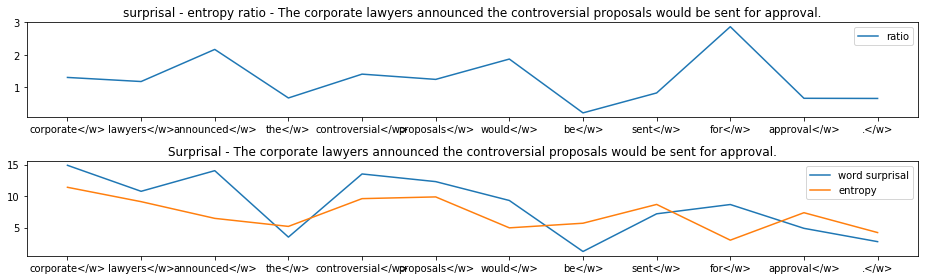

[481, 2609, 6210, 6844, 4013, 481, 36420, 7288, 1275, 485, 1788, 811, 589, 481, 720, 239]


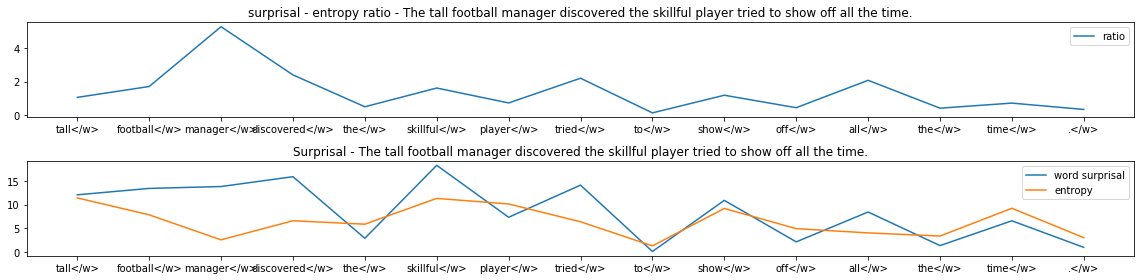

[481, 2609, 15499, 6760, 4013, 481, 1669, 11394, 886, 3438, 13812, 963, 4279, 239]


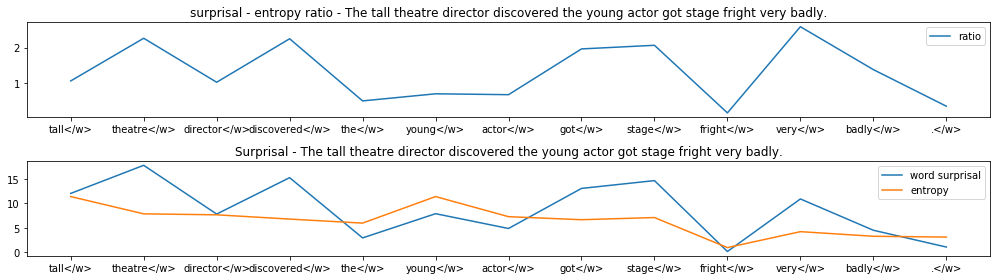

[481, 1669, 1157, 2065, 481, 12924, 7139, 2097, 3852, 1741, 4279, 239]


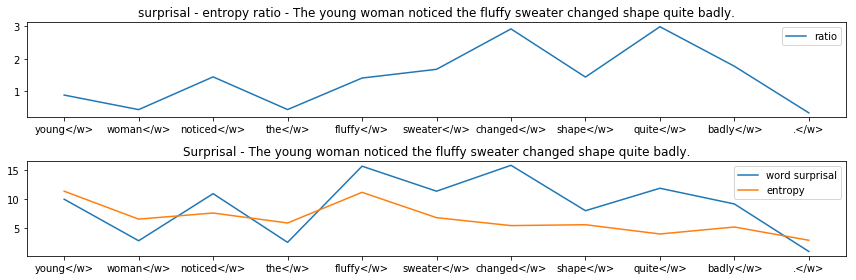

[481, 4066, 2080, 2065, 481, 1080, 6852, 8581, 641, 481, 1593, 10208, 562, 1736, 239]


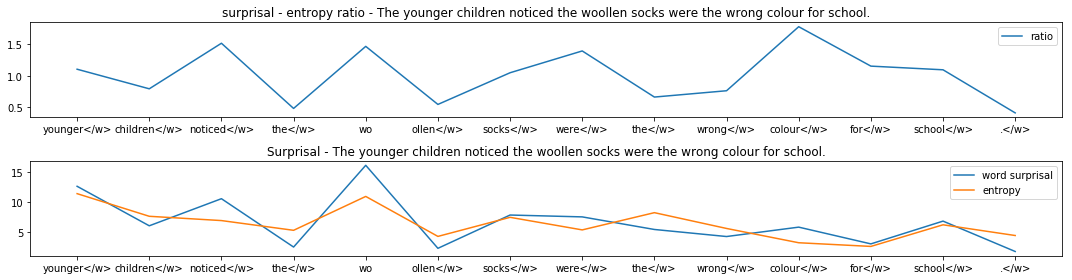

[481, 10402, 6072, 2555, 1057, 481, 5770, 5332, 509, 1036, 13348, 963, 2685, 239]


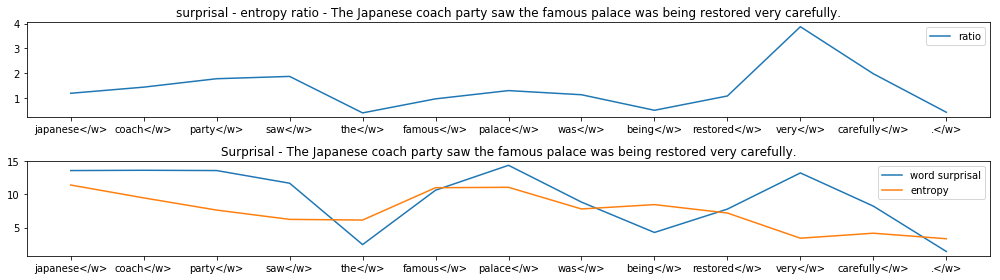

[481, 21995, 1157, 1057, 481, 5770, 2666, 558, 694, 4161, 1741, 246, 1322, 239]


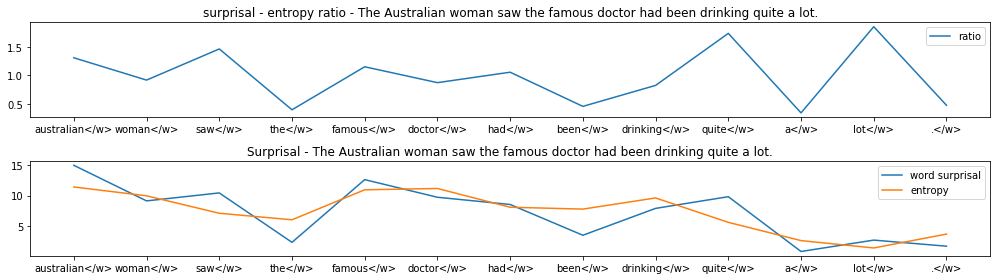

[481, 1122, 5699, 29254, 9744, 481, 7472, 6303, 2139, 963, 1162, 504, 481, 5253, 239]


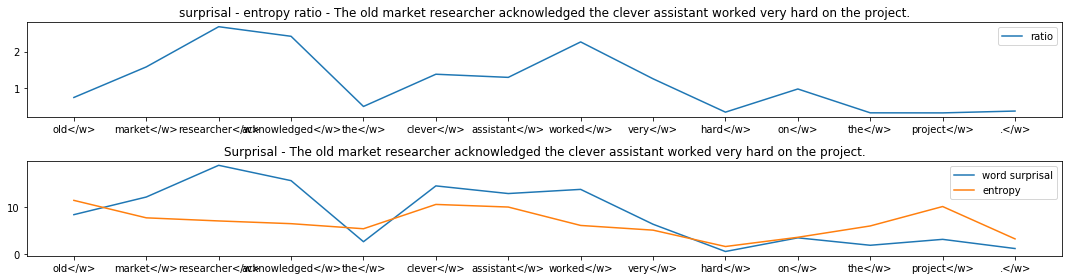

[481, 2609, 5737, 9744, 481, 1669, 6603, 558, 694, 6712, 500, 9700, 481, 10219, 239]


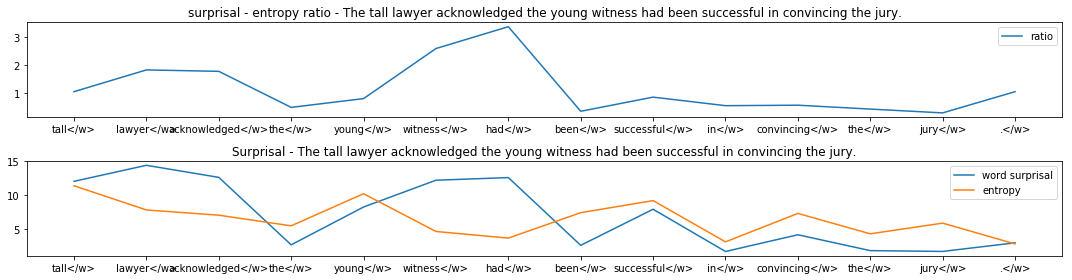

[481, 2609, 8856, 2430, 481, 4160, 4206, 558, 694, 15198, 963, 4525, 239]


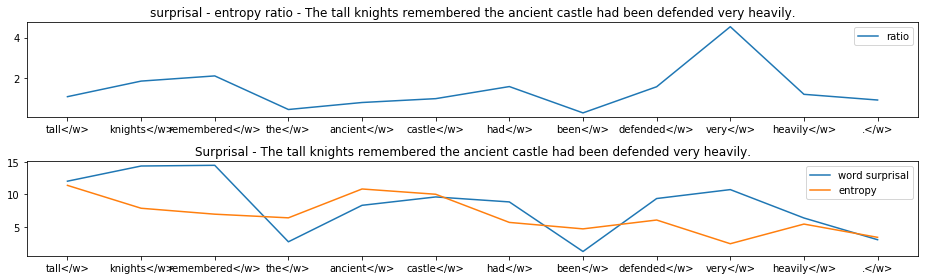

[481, 2609, 9368, 16747, 2430, 481, 29060, 25909, 509, 29827, 963, 1503, 239]


[481, 1122, 3553, 2430, 481, 13921, 1789, 558, 694, 11772, 500, 481, 20690, 2083, 239]


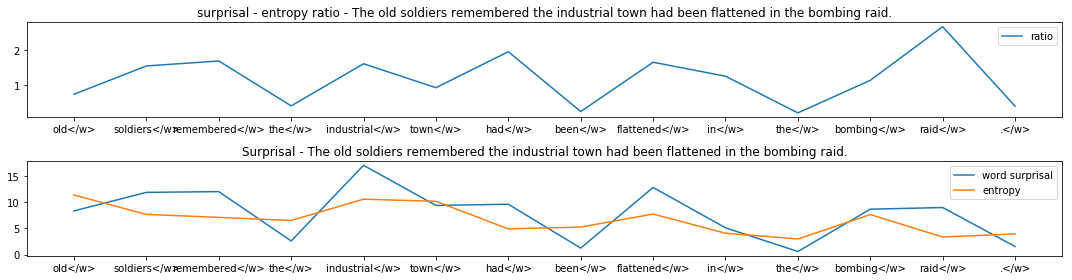

[481, 1393, 17485, 2430, 481, 7061, 3804, 4088, 558, 694, 28228, 702, 481, 34603, 239]


[481, 15345, 22540, 1456, 481, 33621, 20151, 558, 694, 20059, 702, 246, 4817, 239]


[481, 22798, 6425, 9409, 1456, 481, 5770, 7218, 509, 1550, 2389, 556, 987, 23830, 239]


[481, 2609, 25234, 9867, 5658, 481, 8281, 10086, 558, 1374, 3131, 617, 481, 2576, 239]


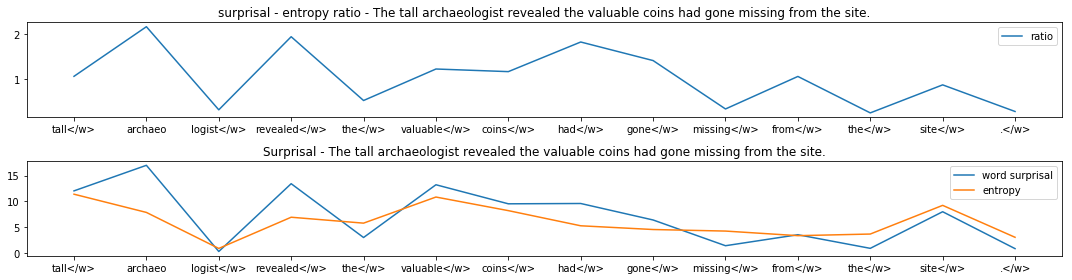

[481, 4413, 2485, 20711, 5658, 524, 18846, 1453, 942, 4447, 500, 481, 2525, 239]


[481, 1669, 18141, 5658, 481, 17407, 19017, 4594, 803, 21670, 617, 481, 26756, 239]


[481, 1122, 7135, 6573, 481, 28497, 4144, 636, 580, 18976, 485, 1272, 989, 239]


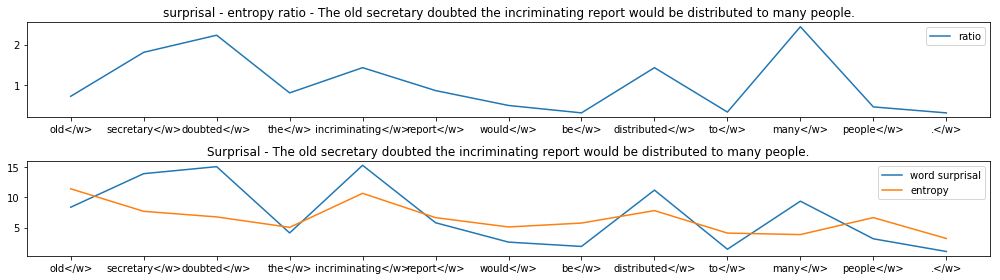

In [131]:
for gp in garden_paths:
    plot_surprisal(gp)

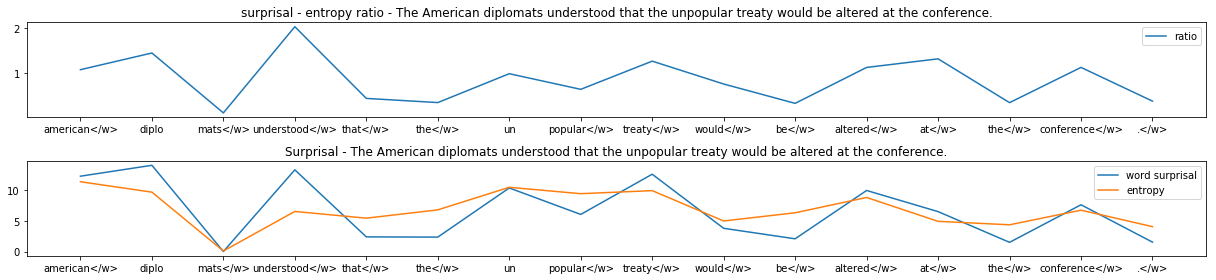

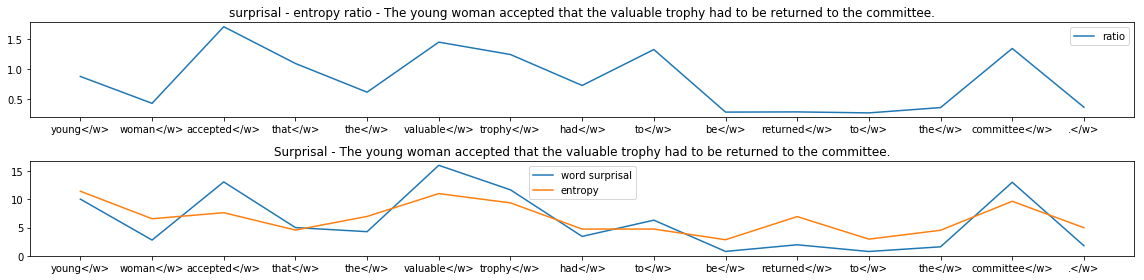

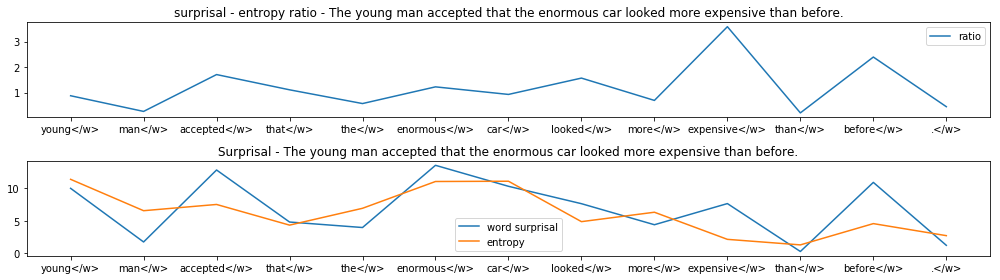

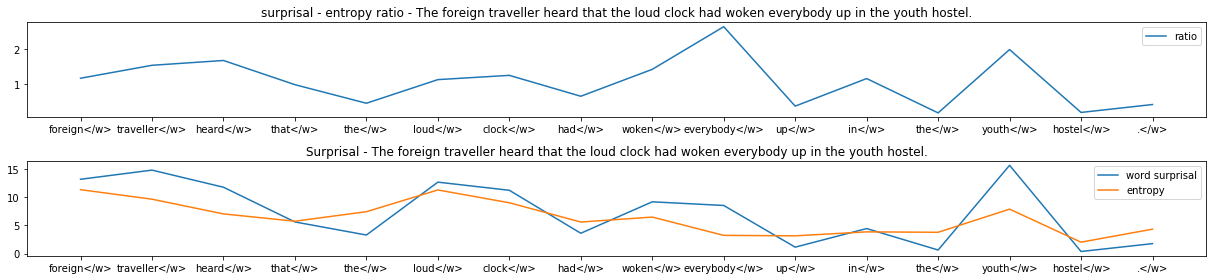

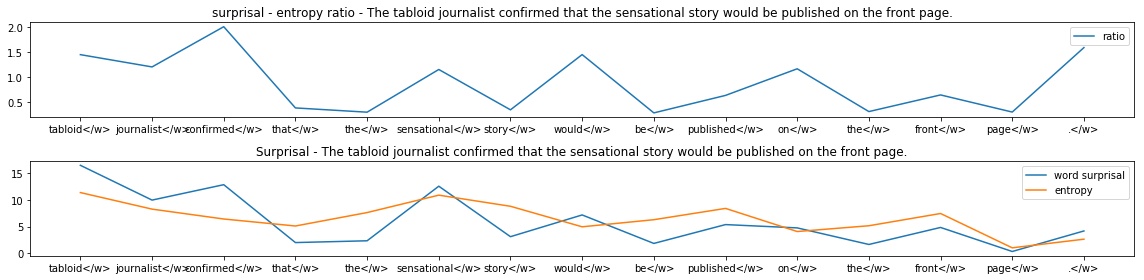

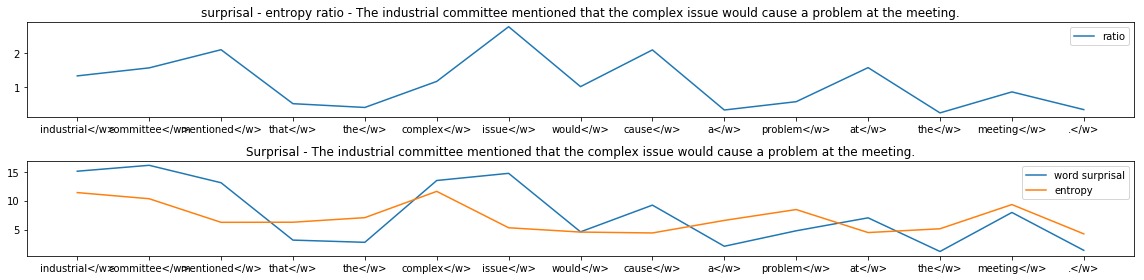

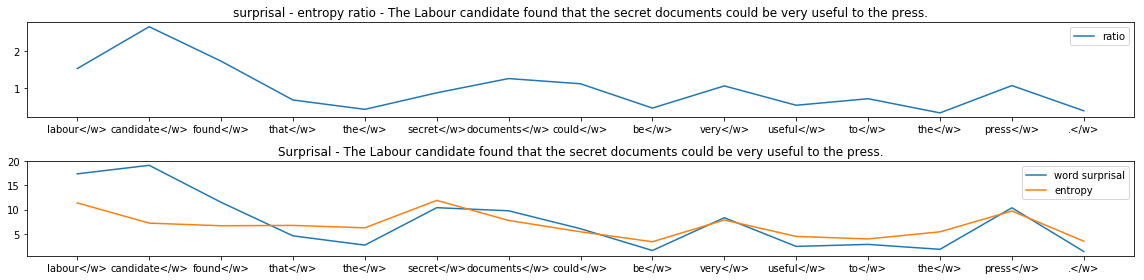

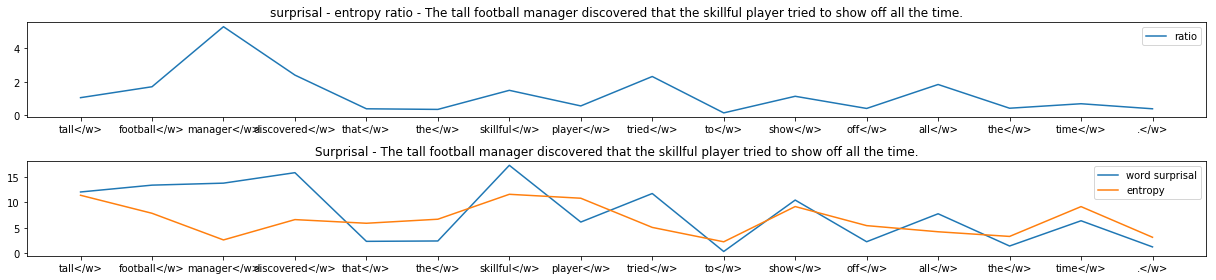

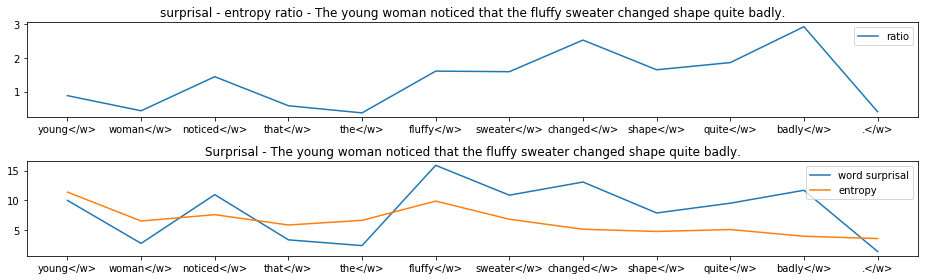

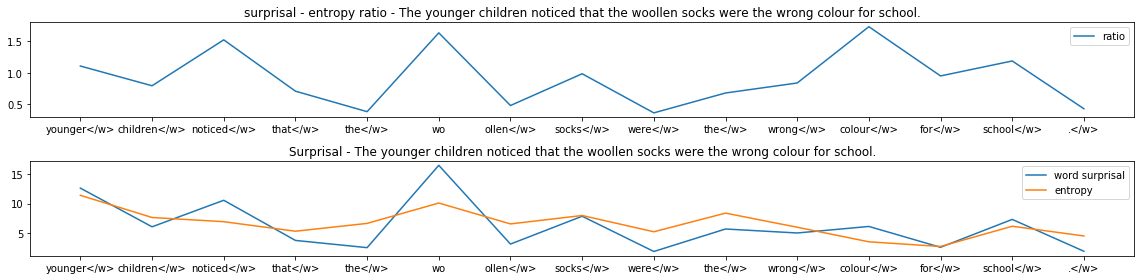

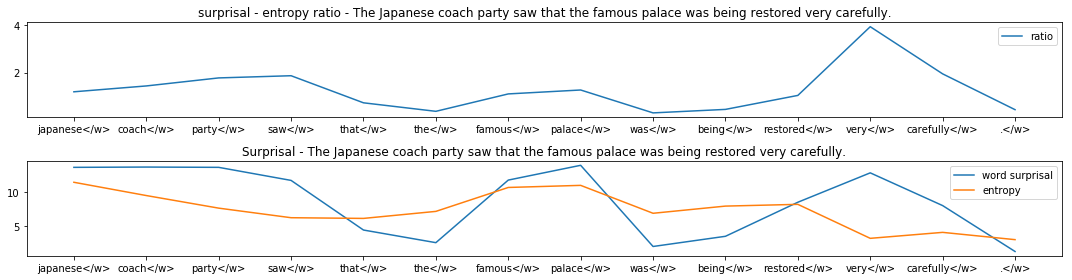

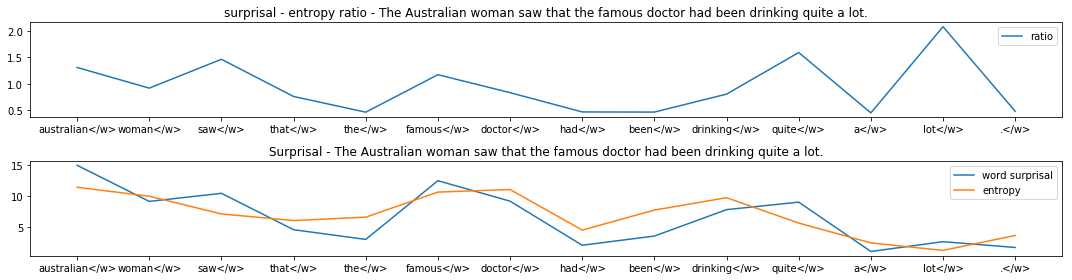

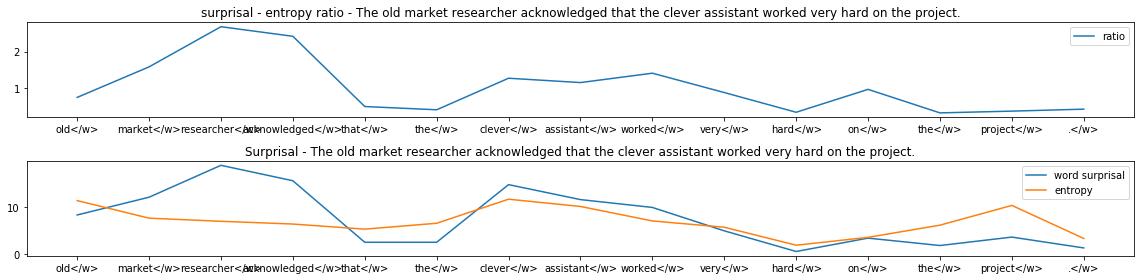

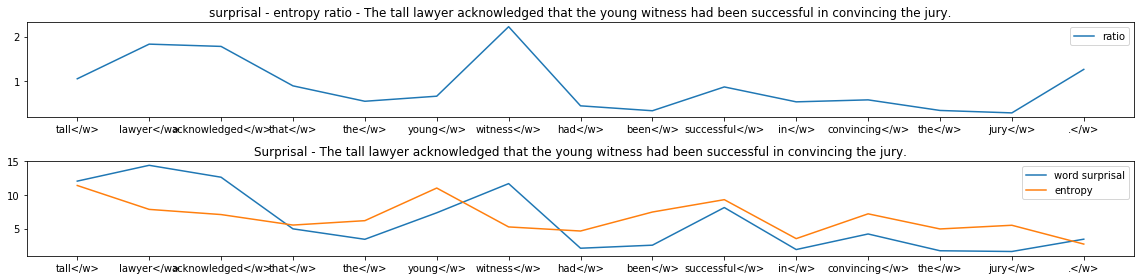

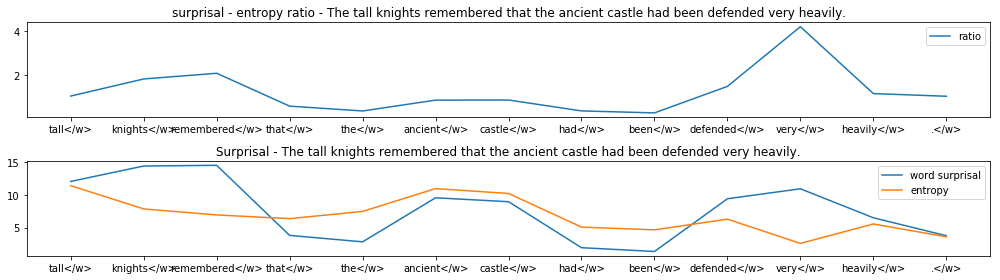

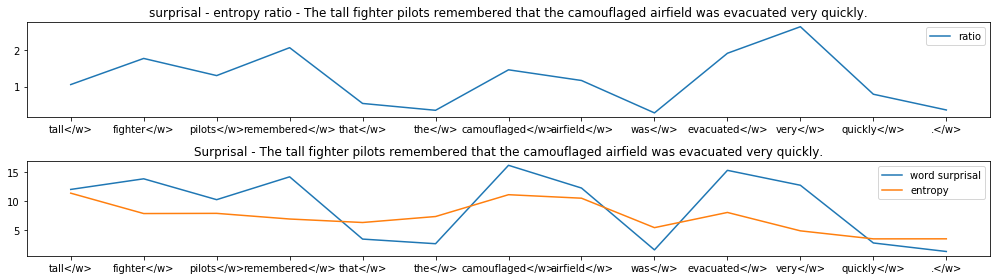

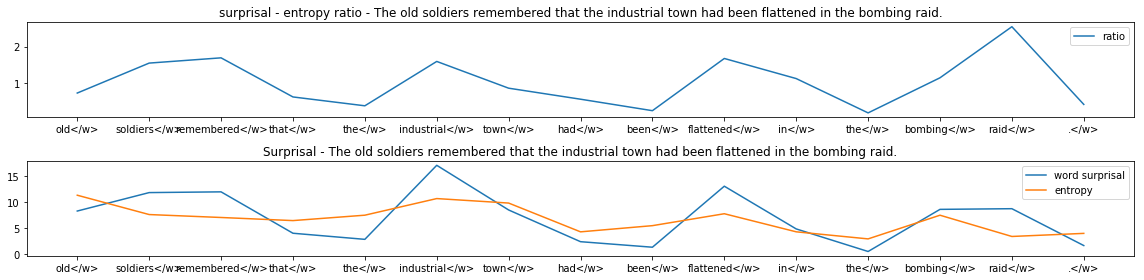

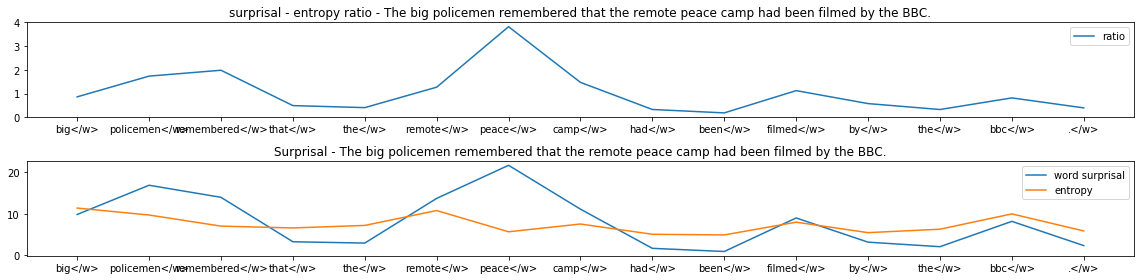

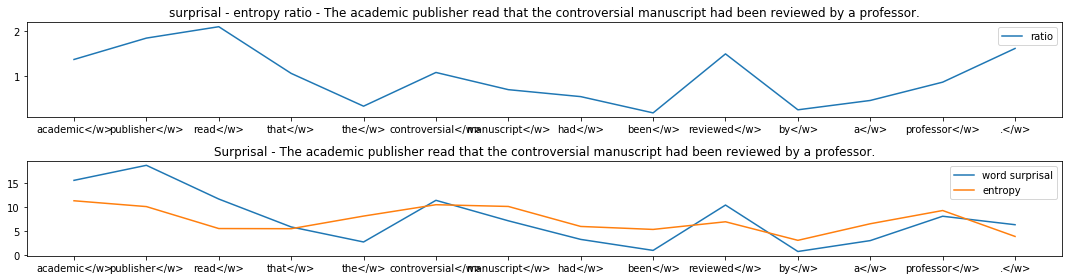

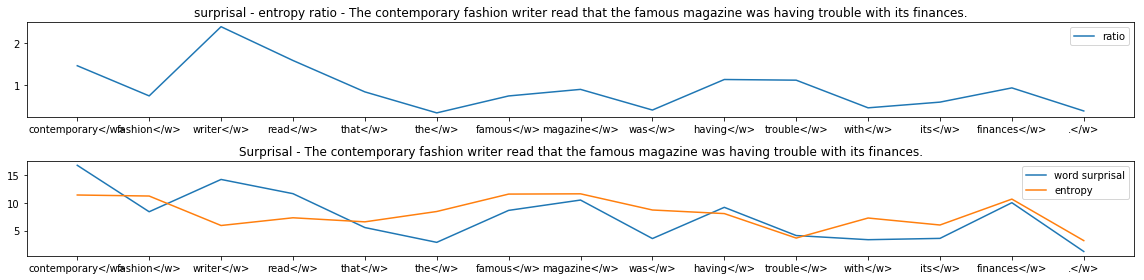

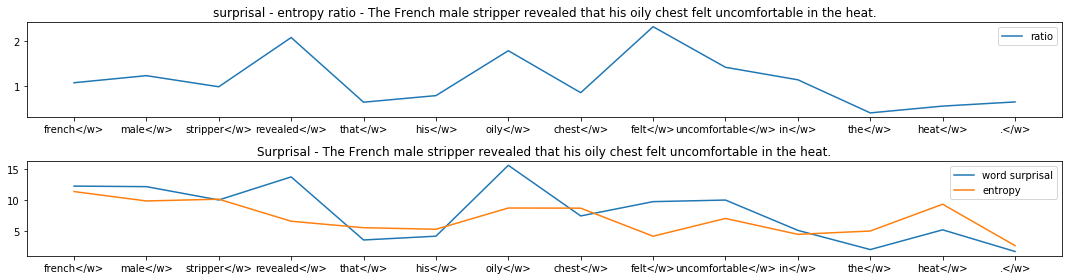

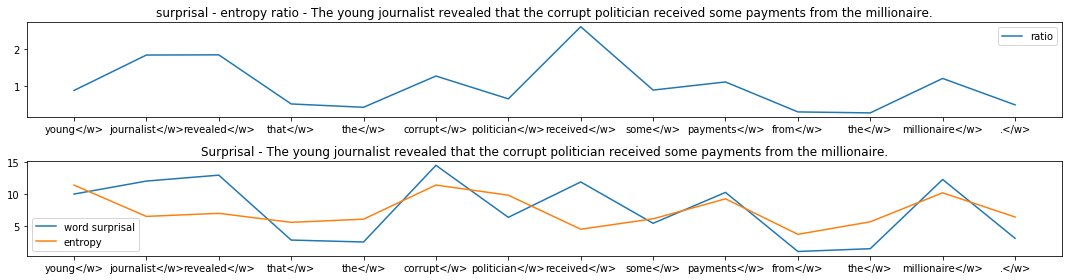

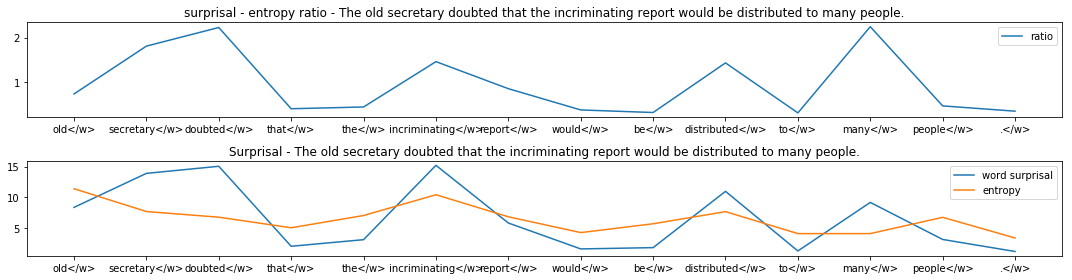

In [136]:
for gpu in garden_paths_unam:
    plot_surprisal(gpu)

In [132]:
gp_ratios_avg = []
for gp in garden_paths:
    _, _, ratios, _ = sa.get_s_h_shr_sentence(gp)
    gp_ratios_avg.append(np.mean(ratios))
print(np.mean(gp_ratios_avg))

[481, 12068, 9425, 2994, 481, 15123, 7049, 636, 580, 2097, 963, 1443, 239]


[481, 4427, 11052, 19720, 2994, 481, 563, 7511, 18756, 636, 580, 12125, 491, 481, 7138, 239]


[481, 1669, 1157, 4617, 481, 8281, 18733, 558, 485, 580, 2118, 485, 481, 11566, 239]


[481, 1669, 762, 4617, 481, 5558, 1267, 816, 725, 5528, 815, 781, 239]


[481, 5440, 1122, 762, 7359, 481, 2540, 4764, 558, 8952, 485, 481, 2666, 239]


[481, 7065, 37159, 1172, 481, 2575, 3275, 558, 9534, 4855, 609, 500, 481, 7341, 25535, 239]


[481, 30198, 18141, 6396, 481, 35267, 1734, 636, 580, 11229, 504, 481, 1130, 4268, 239]


[481, 8426, 7467, 10611, 481, 19304, 2493, 1744, 714, 500, 246, 9771, 239]


[481, 12843, 15443, 4549, 481, 8253, 17668, 509, 1505, 500, 481, 4970, 239]


[481, 13921, 11566, 4033, 481, 6881, 5350, 636, 883, 246, 2204, 491, 481, 2500, 239]


[481, 7585, 3409, 1132, 481, 5528, 5330, 6442, 3953, 1272, 2742, 2167, 481, 11151, 239]


[481, 26478, 14916, 1132, 481, 2752, 9881, 635, 580, 963, 6746, 485, 481, 3336, 239]


[481, 39048, 40145, 4771, 481, 7227, 7176, 558, 2238, 500, 481, 4144, 239]


[481, 11807, 9987, 4771, 481, 33621, 34312, 636, 580, 1655, 562, 7792, 239]


[481, 2609, 6210, 6844, 4013, 481, 36420, 7288, 1275, 485, 1788, 811, 589, 481, 720, 239]


[481, 2609, 15499, 6760, 4013, 481, 1669, 11394, 886, 3438, 13812, 963, 4279, 239]


[481, 1669, 1157, 2065, 481, 12924, 7139, 2097, 3852, 1741, 4279, 239]


[481, 4066, 2080, 2065, 481, 1080, 6852, 8581, 641, 481, 1593, 10208, 562, 1736, 239]


[481, 10402, 6072, 2555, 1057, 481, 5770, 5332, 509, 1036, 13348, 963, 2685, 239]


[481, 21995, 1157, 1057, 481, 5770, 2666, 558, 694, 4161, 1741, 246, 1322, 239]


[481, 1122, 5699, 29254, 9744, 481, 7472, 6303, 2139, 963, 1162, 504, 481, 5253, 239]


[481, 2609, 5737, 9744, 481, 1669, 6603, 558, 694, 6712, 500, 9700, 481, 10219, 239]


[481, 2609, 8856, 2430, 481, 4160, 4206, 558, 694, 15198, 963, 4525, 239]


[481, 2609, 9368, 16747, 2430, 481, 29060, 25909, 509, 29827, 963, 1503, 239]


[481, 1122, 3553, 2430, 481, 13921, 1789, 558, 694, 11772, 500, 481, 20690, 2083, 239]


[481, 1393, 17485, 2430, 481, 7061, 3804, 4088, 558, 694, 28228, 702, 481, 34603, 239]


[481, 15345, 22540, 1456, 481, 33621, 20151, 558, 694, 20059, 702, 246, 4817, 239]


[481, 22798, 6425, 9409, 1456, 481, 5770, 7218, 509, 1550, 2389, 556, 987, 23830, 239]


[481, 2609, 25234, 9867, 5658, 481, 8281, 10086, 558, 1374, 3131, 617, 481, 2576, 239]


[481, 4413, 2485, 20711, 5658, 524, 18846, 1453, 942, 4447, 500, 481, 2525, 239]


[481, 1669, 18141, 5658, 481, 17407, 19017, 4594, 803, 21670, 617, 481, 26756, 239]


[481, 1122, 7135, 6573, 481, 28497, 4144, 636, 580, 18976, 485, 1272, 989, 239]
1.1717919890388564


In [135]:
gp_unam_ratios_avg = []
for gpu in garden_paths_unam:
    _, _, ratios, _ = sa.get_s_h_shr_sentence(gpu)
    gp_unam_ratios_avg.append(np.mean(ratios))
print(np.mean(gp_unam_ratios_avg))

1.0431628427222823


In [138]:
sa.get_continuations("The horse raced past the barn", verbose=True)

The horse raced past the barn
	...,</w> (0.2948)
	...and</w> (0.2644)
	....</w> (0.1994)
	...to</w> (0.0309)
	...with</w> (0.0141)
	...as</w> (0.0123)
	...at</w> (0.0115)
	...door</w> (0.0115)
	...toward</w> (0.0108)
	...before</w> (0.0105)


([',', 'and', '.', 'to', 'with', 'as', 'at', 'door', 'toward', 'before'],
 array([0.2947662 , 0.26438498, 0.19944888, 0.03086027, 0.01409719,
        0.01227125, 0.01153655, 0.0115236 , 0.01081276, 0.01053474],
       dtype=float32))

In [139]:
sa.get_continuations("<unk> The horse raced past the barn", verbose=True)

<unk> The horse raced past the barn
	...and</w> (0.2655)
	...,</w> (0.2598)
	....</w> (0.1320)
	...to</w> (0.0363)
	...door</w> (0.0272)
	...doors</w> (0.0197)
	...with</w> (0.0169)
	...as</w> (0.0168)
	...at</w> (0.0157)
	...in</w> (0.0152)


(['and', ',', '.', 'to', 'door', 'doors', 'with', 'as', 'at', 'in'],
 array([0.2654766 , 0.25980312, 0.13197313, 0.03633862, 0.0272167 ,
        0.01968179, 0.01694696, 0.01681239, 0.01568084, 0.01518688],
       dtype=float32))

In [140]:
sa.get_s_h_shr_sentence("<unk> the")

([16.144482, 8.074623, 7.237762],
 [6.698702975590776, 6.2556811025420895, 7.104126772098918],
 [2.4100906873709715, 1.2907664210422927, 1.018810925891785],
 ['<</w>', 'unk</w>', '></w>', 'the</w>'])

In [143]:
sa.text_encoder.encoder['<unk>']

0

In [13]:
def left_pad_sent(sent, num_unks=3, k=10, verbose=True):
    enc_sent = sa.text_encoder.encode([sent])[0]
    padded_sent = [0] * num_unks + enc_sent
    #print(padded_sent)
    if verbose:
        padded_sent_tensor = sa._get_continuation_tensor([padded_sent])
        words, probs = sa._get_continuations(padded_sent_tensor, k, verbose=True)
    #probs, decs = sa.get_continuation_tensor([padded_sent])[:,-1,:].topk(k)
    #print(probs, decs)
    return padded_sent
    

In [171]:
left_pad_sent("the horse that raced past the barn", 0)

[481, 2914, 525, 5019, 1440, 481, 6076]
	....</w> (0.3594)
	...,</w> (0.2203)
	...and</w> (0.1462)
	...to</w> (0.0240)
	...was</w> (0.0233)
	...with</w> (0.0160)
	...at</w> (0.0138)
	...in</w> (0.0125)
	...toward</w> (0.0091)
	...as</w> (0.0089)


In [172]:
left_pad_sent("the horse that raced past the barn", 1)

[0, 481, 2914, 525, 5019, 1440, 481, 6076]
	....</w> (0.2500)
	...,</w> (0.2171)
	...and</w> (0.1572)
	...was</w> (0.0341)
	...to</w> (0.0241)
	...with</w> (0.0212)
	...in</w> (0.0204)
	...at</w> (0.0193)
	...door</w> (0.0158)
	...on</w> (0.0145)


In [173]:
left_pad_sent("the horse that raced past the barn", 2)

[0, 0, 481, 2914, 525, 5019, 1440, 481, 6076]
	....</w> (0.2148)
	...,</w> (0.1872)
	...and</w> (0.1389)
	...was</w> (0.0672)
	...to</w> (0.0233)
	...in</w> (0.0220)
	...at</w> (0.0170)
	...had</w> (0.0166)
	...with</w> (0.0141)
	...door</w> (0.0139)


In [174]:
left_pad_sent(". the horse raced past the barn", 2)

[0, 0, 239, 481, 2914, 5019, 1440, 481, 6076]
	...,</w> (0.3179)
	...and</w> (0.3145)
	....</w> (0.0651)
	...to</w> (0.0268)
	...with</w> (0.0213)
	...where</w> (0.0189)
	...as</w> (0.0171)
	...in</w> (0.0166)
	...at</w> (0.0156)
	...door</w> (0.0128)


In [175]:
left_pad_sent("the horse raced past the barn", 3)

[0, 0, 0, 481, 2914, 5019, 1440, 481, 6076]
	...and</w> (0.2765)
	...,</w> (0.2634)
	....</w> (0.1376)
	...to</w> (0.0320)
	...in</w> (0.0174)
	...with</w> (0.0168)
	...as</w> (0.0165)
	...door</w> (0.0163)
	...at</w> (0.0162)
	...where</w> (0.0153)


In [177]:
left_pad_sent("the horse raced past the barn", 5)

[0, 0, 0, 0, 0, 481, 2914, 5019, 1440, 481, 6076]
	...and</w> (0.2795)
	...,</w> (0.2536)
	....</w> (0.1318)
	...to</w> (0.0339)
	...in</w> (0.0182)
	...as</w> (0.0177)
	...door</w> (0.0164)
	...at</w> (0.0162)
	...with</w> (0.0161)
	...where</w> (0.0146)


In [178]:
left_pad_sent("the horse raced past the barn", 10)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 481, 2914, 5019, 1440, 481, 6076]
	...and</w> (0.2917)
	...,</w> (0.2382)
	....</w> (0.1247)
	...to</w> (0.0330)
	...door</w> (0.0188)
	...as</w> (0.0180)
	...in</w> (0.0180)
	...with</w> (0.0158)
	...doors</w> (0.0158)
	...at</w> (0.0151)


In [179]:
left_pad_sent(". the horse raced past the barn", 10)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 239, 481, 2914, 5019, 1440, 481, 6076]
	...and</w> (0.3176)
	...,</w> (0.2888)
	....</w> (0.0527)
	...to</w> (0.0295)
	...where</w> (0.0236)
	...with</w> (0.0192)
	...door</w> (0.0185)
	...in</w> (0.0177)
	...as</w> (0.0171)
	...at</w> (0.0153)


In [207]:
sent = "the horse that raced past the barn"
lps0   = left_pad_sent(sent,   0, verbose=False)
lps1   = left_pad_sent(sent,   1, verbose=False)
lps5   = left_pad_sent(sent,   5, verbose=False)
lps10  = left_pad_sent(sent,  10, verbose=False)
lps100 = left_pad_sent(sent, 100, verbose=False)

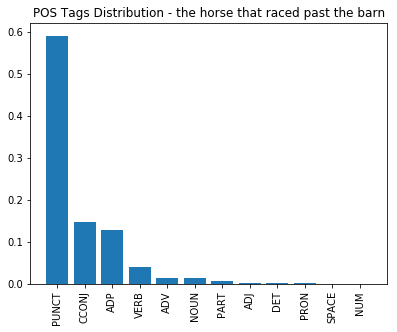

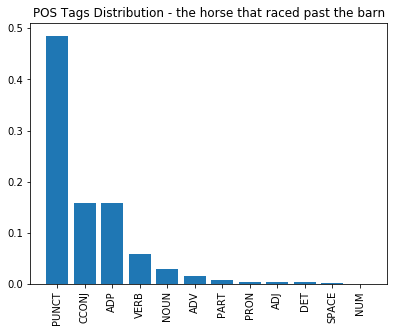

In [213]:
plot_next_pos_dist_ind(sent, lps0)
plot_next_pos_dist_ind(sent, lps1)
plot_next_pos_dist_ind(sent, lps5)
plot_next_pos_dist_ind(sent, lps10)
plot_next_pos_dist_ind(sent, lps100)

Padding: 0


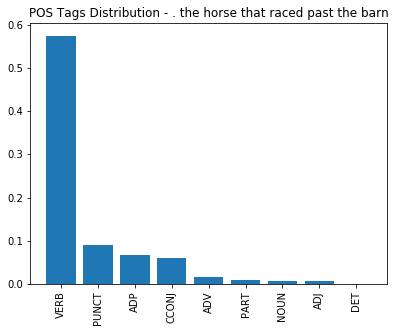

Padding: 1


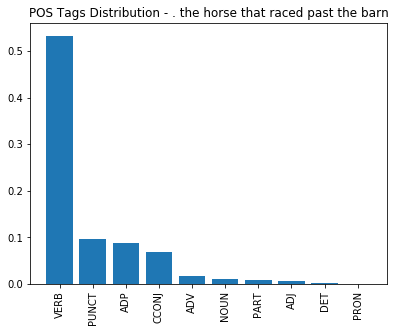

Padding: 5


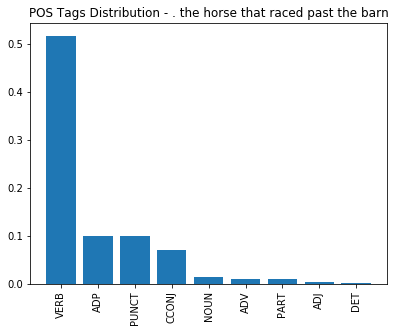

Padding: 10


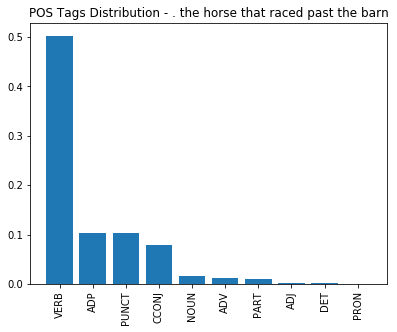

Padding: 100


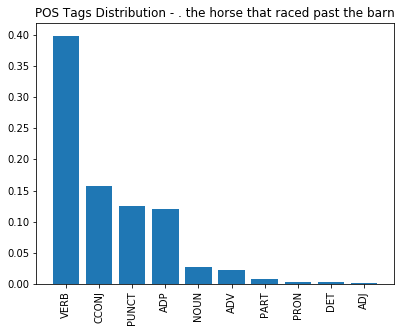

In [215]:
sent = ". the horse that raced past the barn"
lps0   = left_pad_sent(sent,   0, verbose=False)
lps1   = left_pad_sent(sent,   1, verbose=False)
lps5   = left_pad_sent(sent,   5, verbose=False)
lps10  = left_pad_sent(sent,  10, verbose=False)
lps100 = left_pad_sent(sent, 100, verbose=False)
print("Padding: 0")
plot_next_pos_dist_ind(sent, lps0)
print("Padding: 1")
plot_next_pos_dist_ind(sent, lps1)
print("Padding: 5")
plot_next_pos_dist_ind(sent, lps5)
print("Padding: 10")
plot_next_pos_dist_ind(sent, lps10)
print("Padding: 100")
plot_next_pos_dist_ind(sent, lps100)

In [225]:
sa.lm_model.transformer.embed(torch.tensor([0]))

tensor([[ 4.6408e-02, -1.2805e-01, -1.5343e-02,  6.4112e-02, -4.9744e-02,
         -2.0974e-02,  1.2879e-01,  5.9280e-02, -7.9039e-02, -4.4810e-02,
          7.3327e-03, -8.2801e-02, -6.7706e-02, -1.9025e-01, -6.9751e-02,
          6.1687e-02, -2.3319e-02, -6.7211e-02, -4.0688e-02,  7.4863e-02,
         -1.9345e-02, -1.0257e-01, -5.0788e-02, -7.8921e-02,  4.2484e-02,
          1.1210e-01, -1.6808e-02, -9.3247e-02,  1.6577e-01, -1.4455e-02,
          1.5980e-01,  6.8638e-02, -2.9321e-01, -1.7096e-02,  1.3099e-01,
         -2.0758e-03, -3.2160e-02, -7.4617e-02, -7.5901e-02,  1.1471e-01,
          1.9735e-02,  4.0976e-02,  4.9918e-02,  6.8533e-02, -1.8182e-02,
          4.4382e-02, -4.1536e-02, -1.0333e-01, -2.8750e-02,  3.3877e-02,
         -1.0549e-01,  5.0557e-02, -1.4954e-01,  2.6105e-01, -6.6491e-02,
         -1.6149e-01, -3.8617e-02, -1.9096e-01,  1.5398e-01,  1.0815e-01,
          4.8762e-02, -1.1359e-01, -1.4639e-01, -4.7676e-02, -8.5338e-02,
         -7.1682e-02, -3.8363e-02,  1.

In [227]:
sa.lm_model.transformer.embed(torch.tensor([len(sa.text_encoder.encoder) + 1]))

tensor([[-1.4790e-02,  3.1972e-02, -1.8043e-02,  8.5878e-04, -1.2292e-03,
          3.1105e-02, -6.0252e-02,  1.8871e-02,  5.8728e-02, -2.2338e-02,
         -5.1898e-03, -1.7100e-02, -9.2923e-03,  4.8893e-03, -1.6801e-02,
          5.0361e-02,  4.2666e-02, -1.9771e-02,  2.1971e-02, -1.2396e-02,
          6.4725e-03,  6.8889e-03,  3.6612e-02,  3.4235e-02, -5.4170e-02,
         -9.0931e-02,  8.7769e-02, -4.8472e-02, -2.2904e-02,  3.7499e-02,
         -2.8174e-02,  1.1355e-01,  7.2624e-02,  2.3867e-02,  3.9344e-02,
         -3.7909e-02, -4.7602e-02, -1.2851e-02, -1.7306e-02,  2.1144e-02,
         -5.7083e-03, -2.0386e-02,  5.6075e-02,  1.0456e-02,  8.1187e-03,
          6.6156e-02,  2.6229e-02, -2.7154e-02, -2.1707e-02, -2.9544e-02,
          2.4998e-02,  4.8425e-02,  2.0611e-02,  1.4242e-02, -1.7787e-02,
          1.0054e-01, -1.9735e-02, -3.5214e-02, -2.8756e-02,  3.8413e-02,
          6.5700e-02, -1.6814e-02, -2.0454e-02, -3.2780e-02,  1.8043e-02,
          3.3301e-02,  8.5089e-04, -1.

In [228]:
from nltk import sent_tokenize

filename = "/Users/benjaminnewman/Documents/Stanford/CS124/Lectures/Lecture 2 - Unix/nyt_oneline.txt"
with open(filename, "r") as nyt:
    doc = nyt.readlines()

doc = doc[0].strip()
sents = sent_tokenize(doc)

In [229]:
len(sents)

50661

In [230]:
question_sents = sents[:30]

sh_ratios_avg = []
for s in question_sents:
    _, _, ratios, _ = sa.get_s_h_shr_sentence(s)
    sh_ratios_avg.append(np.mean(ratios))
print(np.mean(sh_ratios_avg))

1.2622204727070134


In [247]:
garden_paths_nps[6]

'The tabloid journalist confirmed the sensational story would be published on the front page.'

In [234]:
sa.get_surprisal("The man recalled", "that")

array([3.7245035], dtype=float32)

In [235]:
2**(-3.7245035)

0.07565066108835196

In [238]:
x = "62      4       0       0       0       0       0       0       13      0       9       0       0       2       0       0       0       18      2 0       110".split()

In [239]:
sum(int(xx) for xx in x)

220

In [240]:
13/220

0.05909090909090909

In [241]:
sa.get_surprisal("The man accepted", "that")

array([4.3522882], dtype=float32)

In [246]:
2**(-4.3522882)

0.04895879295326439

In [243]:
x = "98      41      0       0       22      0       0       7       1       0       0       0       0       1       0       0       0       0       30 0       200".split()

In [244]:
1 / sum(int(xx) for xx in x)

0.0025

In [250]:
sa.get_surprisal("The man confirmed", "that")

array([3.75068], dtype=float32)

In [251]:
2**(-3.75068)

0.07429042038124643

In [248]:
x = "61      48      0       0       0       0       0       1       11      0       1       0       1       0       0       0       0       0       7 0       130".split()

In [249]:
11 / sum(int(xx) for xx in x)

0.04230769230769231

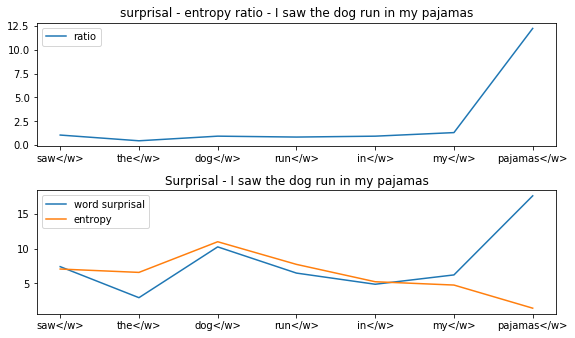

In [252]:
plot_surprisal("I saw the dog run in my pajamas")

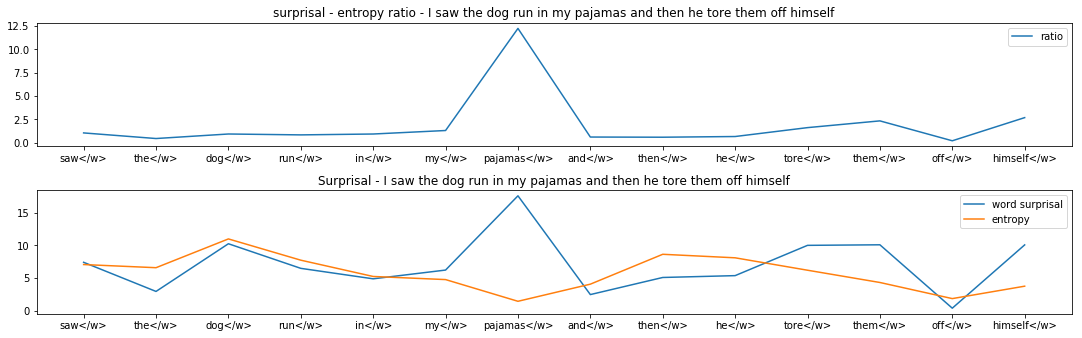

In [253]:
plot_surprisal("I saw the dog run in my pajamas and then he tore them off himself")

In [254]:
garden_paths

['The faithful employees understood the technical contract would be changed very soon.',
 'The American diplomats understood the unpopular treaty would be altered at the conference.',
 'The young woman accepted the valuable trophy had to be returned to the committee.',
 'The young man accepted the enormous car looked more expensive than before.',
 'The extremely old man recalled the angry nurse had complained to the doctor.',
 'The foreign traveller heard the loud clock had woken everybody up in the youth hostel.',
 'The tabloid journalist confirmed the sensational story would be published on the front page.',
 'The construction workers maintained the rickety walls fell down in a heap.',
 'The clumsy apprentice forgot the rusty bicycle was standing in the garage.',
 'The industrial committee mentioned the complex issue would cause a problem at the meeting.',
 'The British army found the expensive medical supplies saved many lives during the conflict.',
 'The Labour candidate found the 

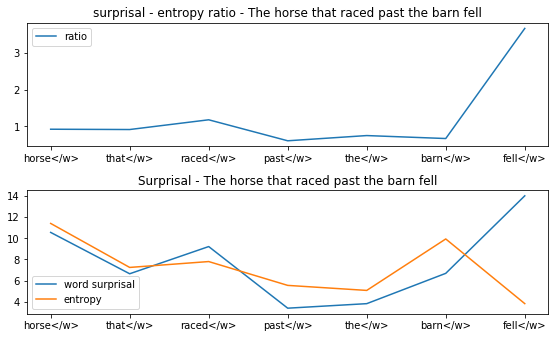

In [255]:
plot_surprisal("The horse that raced past the barn fell")

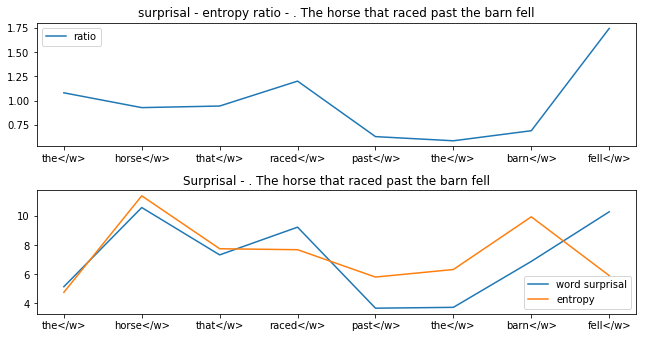

In [256]:
plot_surprisal(". The horse that raced past the barn fell")

fix 

structured decision is tough 

In [257]:
sa.get_pos_continuations("The horse that raced past the barn.", k=1000)

(['SPACE',
  'PRON',
  'DET',
  'PUNCT',
  'ADV',
  'ADP',
  'NOUN',
  'ADJ',
  'VERB',
  'CCONJ',
  'NUM',
  'INTJ',
  'X',
  'PROPN'],
 array([0.2822228 , 0.21743089, 0.1300569 , 0.06599757, 0.05301973,
        0.05079081, 0.04557666, 0.03671471, 0.01600093, 0.00992334,
        0.00927749, 0.00699336, 0.00602638, 0.0012589 ], dtype=float32))

In [258]:
sa.get_pos_continuations("The horse that raced past the barn", k=1000)

(['PUNCT',
  'CCONJ',
  'ADP',
  'VERB',
  'NOUN',
  'ADV',
  'PART',
  'ADJ',
  'DET',
  'PRON',
  'NUM',
  'SPACE'],
 array([5.9220141e-01, 1.4837942e-01, 1.3167228e-01, 5.7005402e-02,
        2.1940062e-02, 1.8310592e-02, 6.1470950e-03, 5.8090910e-03,
        3.5856578e-03, 2.7526505e-03, 9.3610911e-04, 3.8146859e-04],
       dtype=float32))

In [259]:
sa.get_pos_continuations(". The horse that raced past the barn", k=1000)

(['VERB',
  'PUNCT',
  'ADP',
  'CCONJ',
  'ADV',
  'NOUN',
  'ADJ',
  'PART',
  'DET',
  'PRON',
  'NUM',
  'SPACE'],
 array([6.6193008e-01, 9.2107832e-02, 7.8751028e-02, 6.1995570e-02,
        2.8844764e-02, 1.8097252e-02, 1.3147394e-02, 9.1577116e-03,
        2.9864816e-03, 2.3065717e-03, 4.6294762e-04, 2.0284455e-04],
       dtype=float32))

In [397]:
# surprisals_start, _, _, _ = sa.get_s_h_shr_sentence("The horse that raced past the barn fell", start=0)
#s1, _, _, t1 = sa.get_s_h_shr_sentence(". The horse that raced past the barn fell", start=1)
s2, t2 = sa.get_surprisal_sentence("The horse that raced past the barn fell", prepend=[239])

In [583]:
%%time
min_surprisal = float("inf")
min_surprisal_tokens = []
for token_id in range(100):#len(sa.text_encoder.encoder)):
    surprisals2_start, tokens = sa.get_surprisal_sentence("The horse that raced past the barn fell", prepend=[token_id])
    # ignore first token's surprisal, because it is for the first word in the sentence, which isn't well defined
    surprisals2_start = surprisals2_start[1:]
    if sum(surprisals) < min_surprisal:
        min_surprisal = sum(surprisals2_start)
        min_surprisal_tokens = tokens
print(min_surprisal_tokens, min_surprisal)

['.', 'the</w>', 'horse</w>', 'that</w>', 'raced</w>', 'past</w>', 'the</w>', 'barn</w>', 'fell</w>'] 52.53389614790589
CPU times: user 19.8 s, sys: 526 ms, total: 20.4 s
Wall time: 11.8 s


In [19]:
def get_surprisal_sentences(sentence, prepends):
    sentences = []
    sents_decoded = []
    surprisals = []
    sent_encode = sa.text_encoder.encode([sentence])[0]
    sent_dec = [sa.text_encoder.decoder[ind] for ind in sent_encode]
    for index in prepends:
        sentences.append([index] + sent_encode)
        sents_decoded.append([sa.text_encoder.decoder[index]] + sent_dec)
    
    batch = make_batch(sentences)
    
    res_tensor = sa.lm_model(batch)
    for j, sent_enc in enumerate(sentences):
        surprisals.append([])
        #print(sent_enc)
        for i in range(2, len(sent_enc)): # start at 2 so we can ignore the effect of the starting punctuation
            surprisals[j].append(-np.log2(res_tensor[j,i-1,sent_enc[i]].item()))
        
    
    return surprisals, sents_decoded
    #return res_tensor
        

In [27]:
%%time
global_min_tokens = []
global_min_surprisal = float("inf")
di = 400
vocab = len(sa.text_encoder.encoder)
for i in range(0, vocab, di):
    x, y = get_surprisal_sentences("The horse that raced past the barn fell", range(i, min(i+di, vocab)))
    x_sums = np.sum(np.array(x), axis=1)
    min_surprisal_i = np.argmin(x_sums)
    min_surprisal = x_sums[min_surprisal_i]
    min_tokens = y[min_surprisal_i]
    
    if min_surprisal < global_min_surprisal:
        print(min_surprisal_i + i, min_tokens)
        print(min_surprisal)
        global_min_surprisal = min_surprisal
        global_min_tokens = min_tokens

print(global_min_tokens)
print(global_min_surprisal)   

321 ['−</w>', 'the</w>', 'horse</w>', 'that</w>', 'raced</w>', 'past</w>', 'the</w>', 'barn</w>', 'fell</w>']
50.49581236286308


1596 ['suddenly</w>', 'the</w>', 'horse</w>', 'that</w>', 'raced</w>', 'past</w>', 'the</w>', 'barn</w>', 'fell</w>']
50.25857238008901


1889 ['chance</w>', 'the</w>', 'horse</w>', 'that</w>', 'raced</w>', 'past</w>', 'the</w>', 'barn</w>', 'fell</w>']
48.86420997689533


2914 ['horse</w>', 'the</w>', 'horse</w>', 'that</w>', 'raced</w>', 'past</w>', 'the</w>', 'barn</w>', 'fell</w>']
47.944187269939306


9277 ['whistle</w>', 'the</w>', 'horse</w>', 'that</w>', 'raced</w>', 'past</w>', 'the</w>', 'barn</w>', 'fell</w>']
46.40654557465093


20165 ['donkey</w>', 'the</w>', 'horse</w>', 'that</w>', 'raced</w>', 'past</w>', 'the</w>', 'barn</w>', 'fell</w>']
46.02410579451191


['donkey</w>', 'the</w>', 'horse</w>', 'that</w>', 'raced</w>', 'past</w>', 'the</w>', 'barn</w>', 'fell</w>']
46.02410579451191
CPU times: user 45min 57s, sys: 5min 29s, total: 51min 27s
Wall time: 26min 4s


In [30]:
sum(sa.get_surprisal_sentence("The horse raced past the barn fell")[0])

54.6990952853496

In [14]:
def make_batch(X):
    """
    Better version of sa.make_batch that can 
    actually handle more than on sentence at a time...
    """
    torch_batches = []
    for sent in X:
        torch_batches.append(sa.make_batch(sent))
    return torch.cat(torch_batches)
        

In [517]:
res = sa.lm_model(make_batch(enc))

In [519]:
res.shape

torch.Size([2, 3, 40990])

In [513]:
torch.cat([torch.tensor([1, 2, 3]), torch.tensor([1, 2, 3])], axis = -1)

TypeError: cat() got an unexpected keyword argument 'axis'

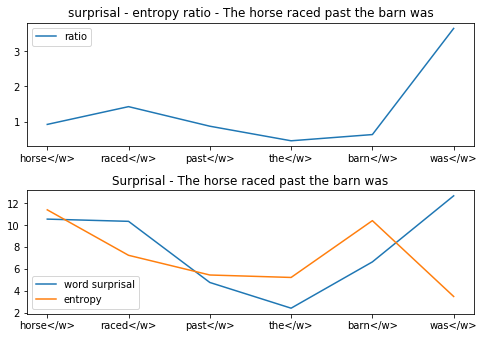

In [38]:
plot_surprisal("The horse raced past the barn was")

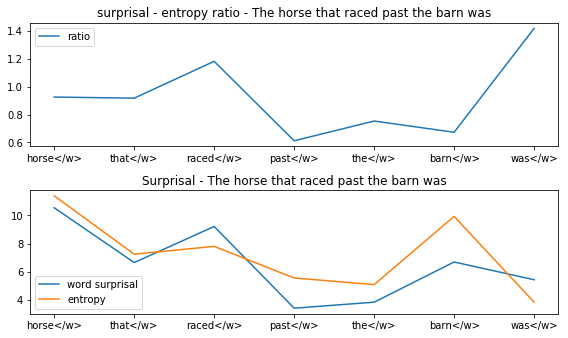

In [40]:
plot_surprisal("The horse that raced past the barn was")

In [33]:
plot_next_pos_dist("The horse that raced past the barn")

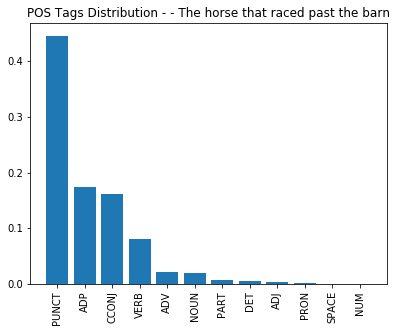

In [34]:
plot_next_pos_dist("- The horse that raced past the barn")

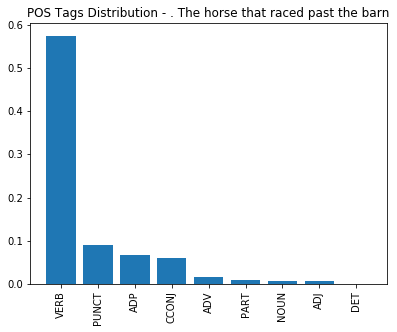

In [35]:
plot_next_pos_dist(". The horse that raced past the barn")